<img src="../images/GFS.jpg" width=400 alt="Ideam_Logo"></img> 

# Global Forecast System - GFS

---

## Introducción
En este cuadernillo (Notebook) aprenderemos:

1. Introduccion al GFS
4. Uso del servidor Thredds
1. Consulta de datos del GFS a escala de 0.5 grados en resolución usando `siphon`
2. Visualización de variables pronosticadas

## Prerequisitos
| Conceptos | Importancia | Notas |
| --- | --- | --- |
| [Introducción a Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necesario | lectura de datos multidimensionales |
| [Introducción a Datetime](https://foundations.projectpythia.org/core/datetime/datetime.html) | Necesario | Entender estampas de tiempo |
| [Introducción a  NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Útil | Entender la metadata de los datos |

- **Tiempo de aprendizaje**: 30 minutos

---

## Librerias

In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime, timedelta
from siphon.catalog import TDSCatalog
from pandas import to_datetime
import cartopy.feature as cf

## 1. GFS

De acuerdo con la documentación [oficial](https://www.emc.ncep.noaa.gov/emc/pages/numerical_forecast_systems/gfs.php) *"El Sistema de Pronóstico Global (GFS) es un modelo de pronóstico del tiempo de los Centros Nacionales de Predicción Ambiental (NCEP) que genera datos para docenas de variables atmosféricas y de suelo-suelo, incluidas temperaturas, vientos, precipitaciones, humedad del suelo y concentración de ozono atmosférico."*

 <img src="../images/GFS - 20120712_0000-small.gif" width=400 alt="Ozone_GFS"></img> <img src="../images/stretch_sat_sandy.gif" width=250 alt="Reticula_GFS"></img> 

Fuente: https://www.ncei.noaa.gov/

* Sistema de Pronóstico Global
* Utilizado comunmente como condiciones iniciales para otros modelos de pronóstico
* El modelo se ejecuta 4 veces al día (00z, 06z, 12z y 18z)
* Prósticos de hasta 16 días. 120 primeras horas son a escala horaria, luego cada 3 horas
* Modelo tiene 127 capas en la vertical
* Utiliza un esquema de esfera cúbica de volumen finito [(FV3)](https://www.gfdl.noaa.gov/fv3/fv3-grids/)
* Resolución/dominio horizontal de 0.5, 1.0 y 2.5 grados

## 2. Acceso a datos del GFS

El acceso a los datos del GFS se puede realizar mediante la descarga directa de los datos utilizando el repositorio de datos del [NCEI](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00631/html) (National Centers for Environmental Information), usando el repositorio de datos de [AWS](https://registry.opendata.aws/noaa-gfs-bdp-pds/), o usando el servidor [Thredds](https://thredds-jumbo.unidata.ucar.edu/thredds/catalog/catalog.html) de la [NCAR](https://ncar.ucar.edu/). Para efectos practicos del curso, utilizaremos la libreria [siphon](https://unidata.github.io/siphon/latest/index.html) que nos permite realizar consultas al servidor `Thredds` usando una API en `Python`. 

Para consultar el modelo GFS con resolición espacial de 0.25 grados utilizamos el módulo `TDSCatalog` y pasamos el link correspondiente que se puede obtener [acá](https://thredds-jumbo.unidata.ucar.edu/thredds/catalog/catalog.html)

In [2]:
gfs_url = 'http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best'
best_gfs = TDSCatalog(gfs_url)
best_gfs

Best GFS Quarter Degree Forecast Time Series

Para acceder a este conjunto de datos usando `Xarray.Dataset` simplemente creamos un acceso remoto de la siguiente manera

In [3]:
ds_gfs = best_gfs.datasets[0].remote_access(use_xarray=True)
print(f'size: {ds_gfs.nbytes / (1024 ** 3)} GB')
display(ds_gfs)

size: 542.7065934985876 GB


<xarray.Dataset>
Dimensions:                                                                     (
                                                                                 time2: 344,
                                                                                 : 2,
                                                                                 time3: 188,
                                                                                 pressure_difference_layer: 1,
                                                                                 depth_below_surface_layer: 4,
                                                                                 ...
                                                                                 height_above_ground: 1,
                                                                                 height_above_ground5: 2,
                                                                                 height_above_ground3: 3,
                                                                                 height_above_ground2: 7,
                                                                                 sigma: 1,
                                                                                 hybrid: 1)
Coordinates: (12/31)
  * lat                                                                         (lat) float32 ...
  * lon                                                                         (lon) float32 ...
  * time                                                                        (time) datetime64[ns] ...
    reftime                                                                     (time) datetime64[ns] ...
  * time1                                                                       (time1) datetime64[ns] ...
    reftime1                                                                    (time1) datetime64[ns] ...
    ...                                                                          ...
  * isobaric1                                                                   (isobaric1) float32 ...
  * height_above_ground4                                                        (height_above_ground4) float32 ...
  * height_above_ground5                                                        (height_above_ground5) float32 ...
  * sigma                                                                       (sigma) float32 ...
  * hybrid                                                                      (hybrid) float32 ...
  * hybrid1                                                                     (hybrid1) float32 ...
Dimensions without coordinates: 
Data variables: (12/180)
    LatLon_Projection                                                           int32 ...
    time2_bounds                                                                (time2, ) datetime64[ns] ...
    time3_bounds                                                                (time3, ) datetime64[ns] ...
    pressure_difference_layer_bounds                                            (pressure_difference_layer, ) float32 ...
    depth_below_surface_layer_bounds                                            (depth_below_surface_layer, ) float32 ...
    height_above_ground_layer_bounds                                            (height_above_ground_layer, ) float32 ...
    ...                                                                          ...
    Pressure_potential_vorticity_surface                                        (time, potential_vorticity_surface, lat, lon) float32 ...
    Temperature_potential_vorticity_surface                                     (time, potential_vorticity_surface, lat, lon) float32 ...
    u-component_of_wind_potential_vorticity_surface                             (time, potential_vorticity_surface, lat, lon) float32 ...
    v-component_of_wind_potential_vorticity_surface                             (time, potential_vorticity_surface, lat,

El dato descargado desde el servidor Thredds trae un error en el formato de las coordenadas. Para evitar tropiezos mas adelante cuando realicemos selección de datos más adelante reemplazaremos las coordenadas de la siguiente manera

In [4]:
# ds_gfs.sel(lat=0, method='nearest')

In [5]:
ds_gfs = ds_gfs.assign_coords(lat=("lat", np.linspace(90, -90, 721)), lon=('lon', np.linspace(0, 360, 1440)))

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Peligro</p>
    Este archivo pesa alrededor de 530 GB. No trate de cargarlo en memeria a menos que tenga la capacidad suficiente en RAM. Se recomienda hacer consultas específicas en variables, espacio y tiempo.  
</div>

Para realizar consultas a variables de interes podemos utilizar el método `.sel` al igual que utilizar la notación `punto` o de `diccionarios` para acceder a variables de interes. Consultemos entonces variables como la temperatura, humedad, presión entre otros. 

In [6]:
var = ['Temperature_surface', 'Pressure_surface', 'Precipitation_rate_surface', 'Relative_humidity_height_above_ground']
ds_subset = ds_gfs[var]
display(ds_subset)

<xarray.Dataset>
Dimensions:                                (time: 189, lat: 721, lon: 1440,
                                            height_above_ground4: 1)
Coordinates:
  * time                                   (time) datetime64[ns] 2023-10-06 ....
    reftime                                (time) datetime64[ns] ...
  * height_above_ground4                   (height_above_ground4) float32 2.0
  * lat                                    (lat) float64 90.0 89.75 ... -90.0
  * lon                                    (lon) float64 0.0 0.2502 ... 360.0
Data variables:
    Temperature_surface                    (time, lat, lon) float32 ...
    Pressure_surface                       (time, lat, lon) float32 ...
    Precipitation_rate_surface             (time, lat, lon) float32 ...
    Relative_humidity_height_above_ground  (time, height_above_ground4, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

Por alguna razon los datos utilizan algunas veces la dimension `time` y otras veces `time1`. Para evitar errores podemos controlar eso de la siguiente manera

In [7]:
try: 
    ds_subset.Temperature_surface.time
except AttributeError as e:
    print(e)
    ds_subset = ds_subset.assign_coords(time=ds_subset.time1)

## 3. Salidas gráficas a partir de los datos de GFS

Como ya sabemos, una vez tenemos nuestro datos en un objeto `Xarray.Dataset` podemos generar gráficos de manera rápida. Por ejemplo podemos ver la temperatura pronósticada para el día de mañana

In [8]:
current_dateTime = datetime.now()
tomorrow = current_dateTime + timedelta(days=1)
tomorrow

datetime.datetime(2023, 10, 14, 14, 53, 34, 294195)

Formateamos la fecha a un string para hacer el filtrado en nuestro `Dataset`

In [9]:
fecha = f"{tomorrow:%Y-%m-%d}"
fecha

'2023-10-14'

Ahora generamos nuestra salida gráfica de la temperatura usando `matplotlib`

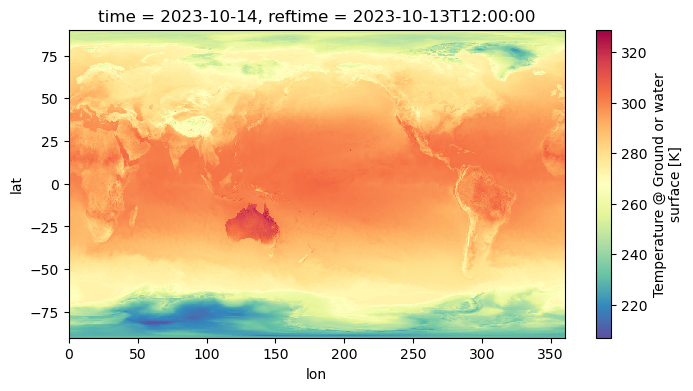

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
ds_subset['Temperature_surface'].sel(time=fecha, method='nearest').plot(cmap='Spectral_r', ax=ax)

Utilizando [`Cartopy`](https://scitools.org.uk/cartopy/docs/latest/) podemos trabajar con [sistemas coordenados de referencia](https://scitools.org.uk/cartopy/docs/latest/reference/crs.html) (CRS por sus siglas en ingles Cordinate reference Systems) y diferentes [proyecciones](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html). Como ejemplo, trabajaremos con un proyección `Mollweide` con centro sobre Colombia (285° en longitud Aprox.)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={"projection":ccrs.Mollweide(central_longitude=285)}, dpi=150)

ds_subset['Temperature_surface'].sel(time=fecha, method='nearest').plot(ax=ax, cmap='Spectral_r', 
                                                                         transform=ccrs.PlateCarree(), 
                                                                         cbar_kwargs={'label':"$Temperatura \ [°C]$", 
                                                                                      'orientation':'horizontal', 
                                                                                      'aspect':50})
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
plt.title(f"Temperatura [°C] - {fecha}");

Podemos generar un gráfico para Colombia y sus alrededores de la siguiente manera

In [ ]:
ds_col = ds_subset.sel(lat=slice(20, -10), lon=slice(270, 310))
display(ds_col)

De igual modo podemos visualizar los datos usando `contour` y `contourf`. A continuación, podemos observar los gráficos de la temperatura, presión, precipitación y humedad relativa

In [ ]:
# Creacion del "lienzo"
fig, ax = plt.subplots(figsize=(7, 4), subplot_kw={"projection":ccrs.PlateCarree(central_longitude=285)}, dpi=150)

# Grafico de variables
# (ds_col.Pressure_surface.sel(time=f"{fecha} 12:00") / 100).plot.contour(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis_r', 
#                                              linewidths=0.5,
#                                             levels=np.arange(500, 1000, 100))
# (ds_col.Temperature_surface.sel(time=f"{fecha} 12:00") - 273.15).plot.contourf(ax=ax, cmap='Spectral_r', transform=ccrs.PlateCarree(), 
#                                          levels=np.arange(0, 35, 1))
ds_col.Relative_humidity_height_above_ground.sel(time1=f"{fecha} 12:00").isel(height_above_ground4=0).plot.contourf(ax=ax, 
                                                                                        cmap='viridis', 
                                                                                        transform=ccrs.PlateCarree(), 
                                                                                       levels=np.arange(0, 101, 10))

# (ds_col.Precipitation_rate_surface.sel(time=f"{fecha} 12:00") * 86400).plot.contourf(ax=ax,
#                                                           transform=ccrs.PlateCarree(),
#                                                           levels=np.arange(0, 50, 1))

# Adicionamos lineas costeras y división entre paises
ax.coastlines()
ax.add_feature(cf.BORDERS)

# Agregar las lineas de reticula
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
plt.title(f"{to_datetime(ds_col.sel(time=f'{fecha} 12:00').time.values):%Y-%m-%d %H%M} UTC");

Podemos gener series de tiempo con los valores pronoticados para una ubicacion en particular. Utilicemos la ubicación de la Universidad del Quindio como ejemplo `lat=4.54` y `lon=-75.68`

In [ ]:
ds_uniq = ds_col.sel(lat=4.54, lon=360 -75., method='nearest')
ds_uniq

In [ ]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(4,1, figsize=(10, 6), sharex=True)
(ds_uniq.Pressure_surface / 100).plot(ax=ax)
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("Press [hPa]")
(ds_uniq.Temperature_surface - 273.15).plot(ax=ax1)
ax1.set_title("")
ax1.set_xlabel("")
ax1.set_ylabel("Temp [°C]")
(ds_uniq.Precipitation_rate_surface * 86400).plot(ax=ax2)
ax2.set_title("")
ax2.set_xlabel("")
ax2.set_ylabel("RR [mmhr-1]")
ds_uniq.Relative_humidity_height_above_ground.isel(height_above_ground4=0).plot(ax=ax3)
ax3.set_title("")
ax3.set_xlabel("")
ax3.set_ylabel("HR [%]")

Otra variables disponibles en el modelo GFS pueden ser gráficadas

---

## Conclusiones
En este cuadernillo aprendimos a consultar datos provenientes del modelo Global Forecast System usando la libreria `Siphon` disponibles en el servidor Thredds de la NCAR. Aprendimos a generar gráficos espaciales y series temporales de pronósticos para multiples variables usando `Xarray`, `Cartopy` y `Matplotlib`. 

## Resources and references
* [Global Forecast System (GFS)](https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast)
* [TDS Online Tutorial](https://docs.unidata.ucar.edu/tds/current/userguide/index.html)